### Train a machine learning model 

#### Step 1: Setup 

In [1]:
import pandas as pd
import os
import sklearn
import shap
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_validate,RandomizedSearchCV
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
from trainMLmodel import surfaceDesignTopAndBottom,selectDescriptors,combineRankAndDescriptorsClassyfication,explainer

#### Step 2: load the data file

In [2]:
# Define the location of the csv files imageOutliersRemoved and Ranking
pathToImageObject=os.getcwd()+"/DataAnalysis/"       
locationOfImageObject1=pathToImageObject+"imageOutliersRemoved.csv"
locationOfImageObject2=pathToImageObject+"Ranking.csv"
# Define the location of the annotation files
pathToTopoUnitImages=os.getcwd()+"/AnnotationFiles/FeatureImages/"
allTopoDescriptors=pd.read_csv(os.getcwd()+"/AnnotationFiles/allTopoDescriptors.csv")
# check if file exists
if os.path.isfile(locationOfImageObject1):
    imagedataOutliersRemoved=pd.read_csv(locationOfImageObject1,low_memory=False)
    if os.path.isfile(locationOfImageObject2):
        imageDataRankedSurfaces=pd.read_csv(locationOfImageObject2,low_memory=False)
    else:
        print("File not found, check if you finished ranking the features")
else:
    print('File not find, check if you removed the outliers')


#### Step 3: Select Features for the machine learning.

##### Step 3.1 Vizualize the topographies design from top and bottom of the rank.

First, select the feature of interest

In [3]:
featureOfInterest='Screen_SNR_Count_CellBody'

Second, select the number of top and bottom ranked feautures you want to select

In [4]:
numberOfRankedFeaturesToVisualize=27

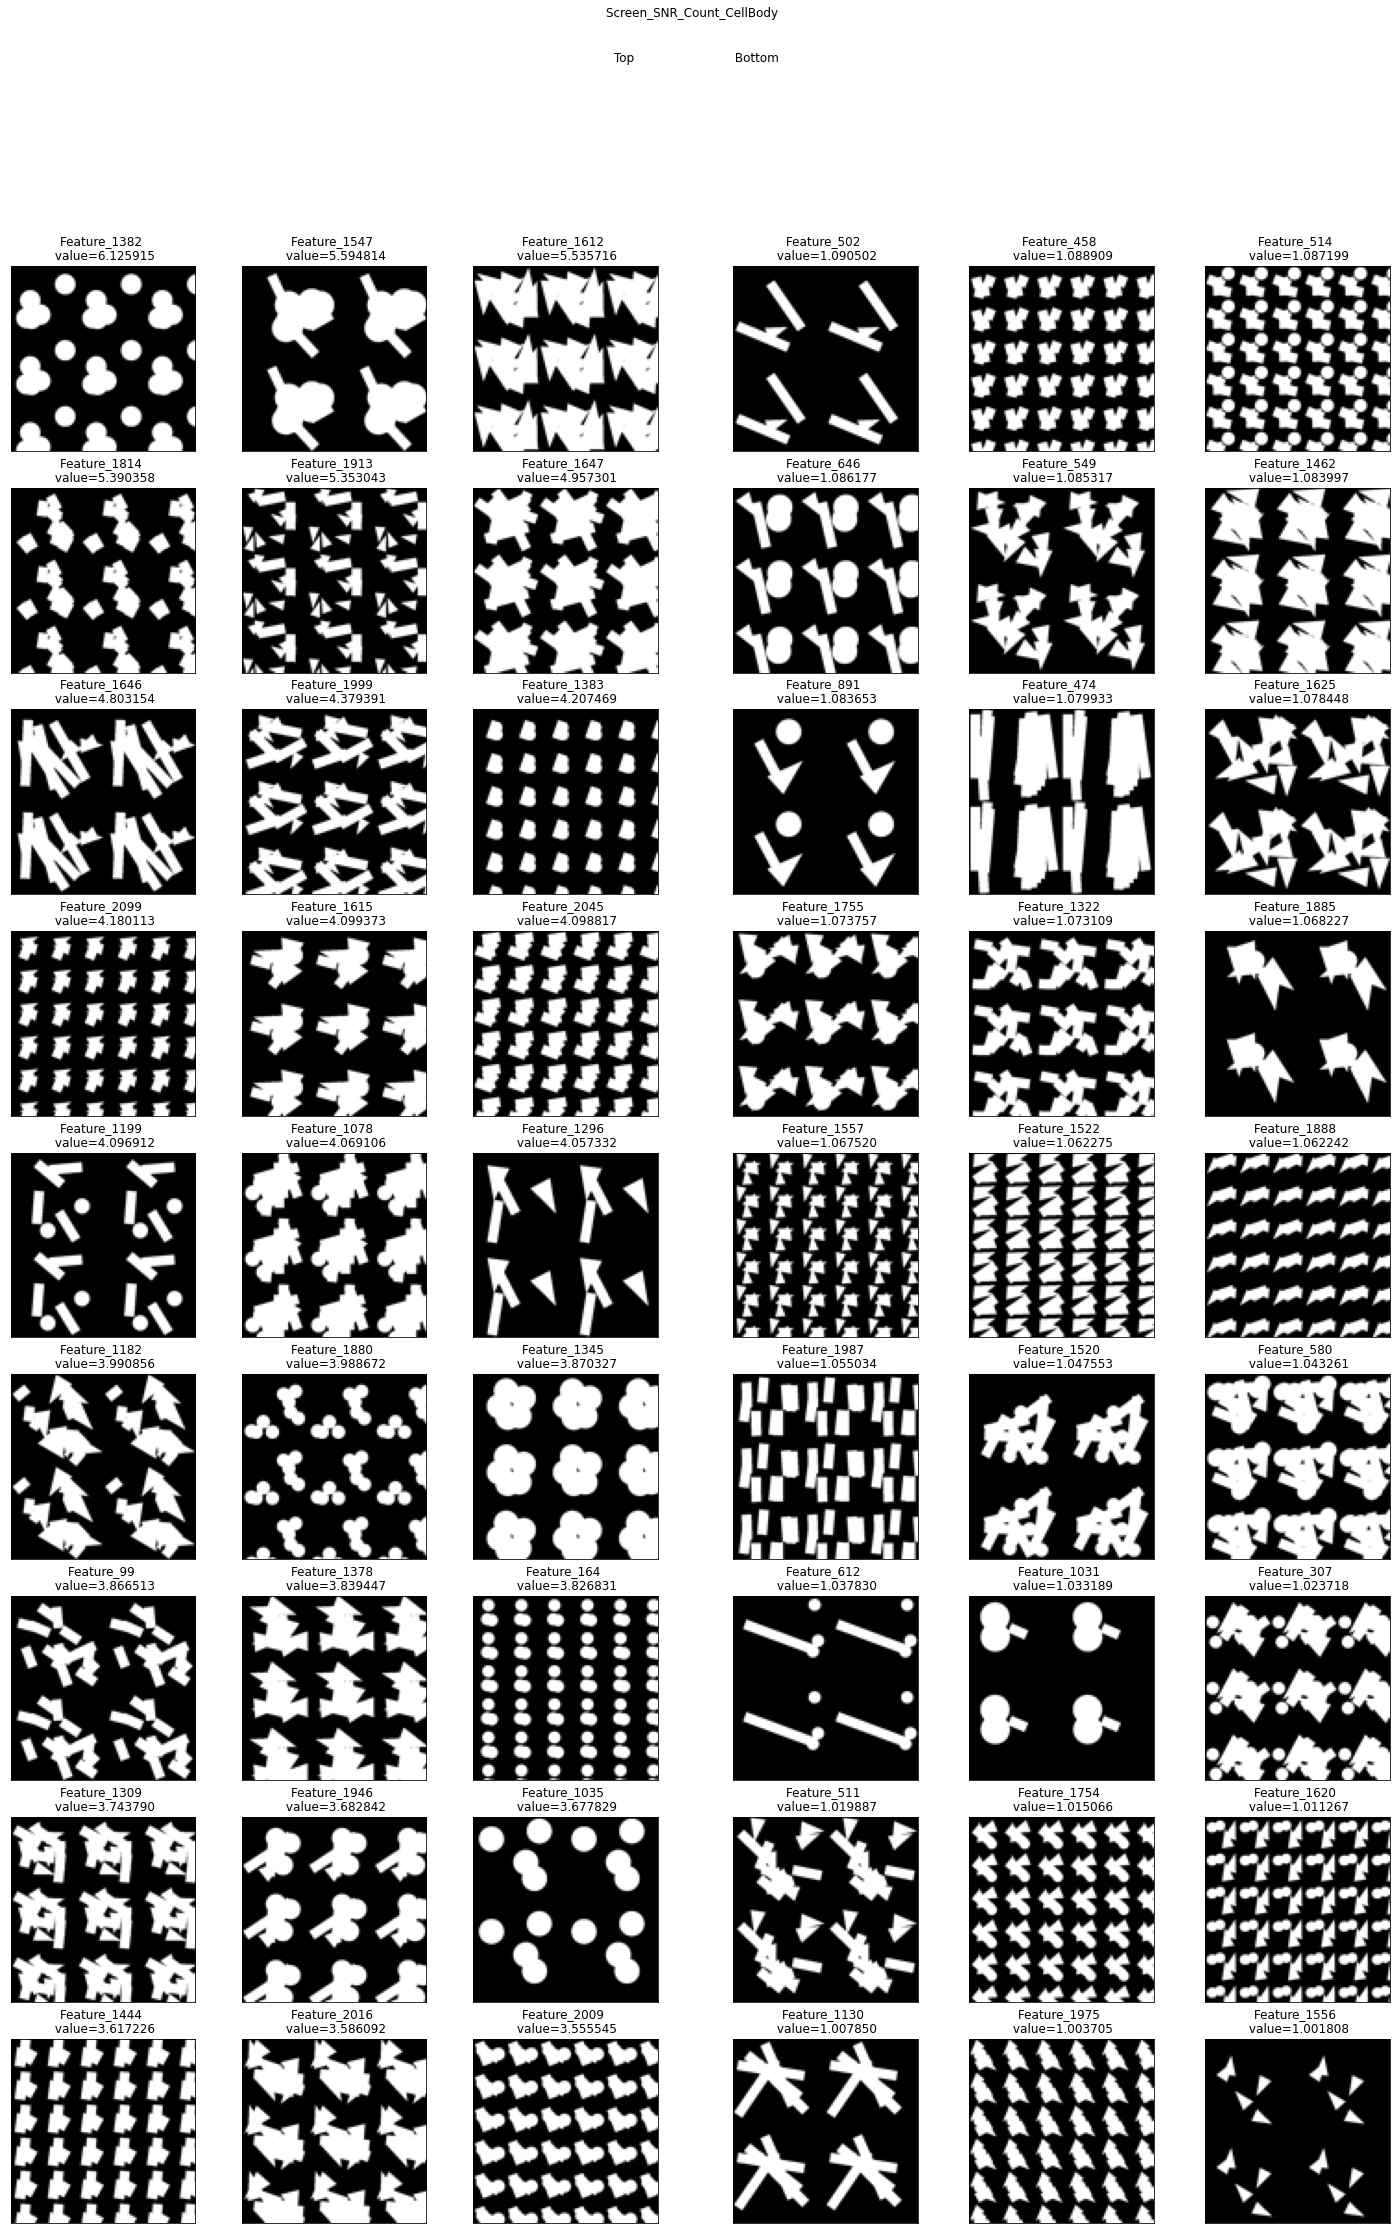

In [5]:
surfaceDesignTopAndBottom(imageDataRankedSurfaces,pathToTopoUnitImages,featureOfInterest,number=numberOfRankedFeaturesToVisualize)

### Step 4 Load and vizualize descriptors data

##### Step 4.1 select descriptors based on a keyword 

In [6]:
selectedDescriptors= selectDescriptors(allDescriptors=allTopoDescriptors,
              #  keywordsToInclude=["Pattern","Kamiel"],
                  keywordsToExclude=["Zernike","_Index","Height","Width", "Center","Texture"])

### Step 5: Train Machine Learning models

##### Step 5.1 : train the model based on the ranked surfaces and the descriptors selected in step 4.1

In [7]:
X,Y=combineRankAndDescriptorsClassyfication(SortedRank=imageDataRankedSurfaces,
                                               Descriptors=selectedDescriptors,
                                               numberPerClass=300)

##### Step 5.2: split X and Y in training and test data set

In [8]:
X_train,X_test,y_train,y_test=train_test_split(X,Y)

##### Step 5.3: select a classification model

In [9]:
classyficationModel = XGBClassifier()

Step 5.4: find the most optimal parameters for the classification model 

In [10]:
searchParameters = {
            'min_child_weight': [0.1, 1, 5, 10, 50],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [5, 10, 25, 50],
            'learning_rate': [0.0001, 0.001, 0.1, 1],
            'n_estimators': [50, 100, 250, 500],
            'reg_alpha': [0.0001, 0.001, 0.1, 1],
            'reg_lambda': [0.0001, 0.001, 0.1, 1]
                    }

fitingParameters={
            "early_stopping_rounds":10,
            "eval_metric" : "auc", 
            "eval_set" : [[X_train, y_train]]
                   }

random_search = RandomizedSearchCV(
                classyficationModel, 
                cv=5,
                param_distributions=searchParameters, 
                scoring='roc_auc', 
                n_jobs=-1,
                verbose=10, 
                random_state=0,
                        )

searchModel=random_search.fit(X_train, y_train, **fitingParameters)
bestParameters=searchModel.best_estimator_.get_params()

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0]	validation_0-auc:0.75587
[1]	validation_0-auc:0.78458
[2]	validation_0-auc:0.80452
[3]	validation_0-auc:0.80203
[4]	validation_0-auc:0.80072
[5]	validation_0-auc:0.81092
[6]	validation_0-auc:0.81571
[7]	validation_0-auc:0.81221
[8]	validation_0-auc:0.81390
[9]	validation_0-auc:0.81450
[10]	validation_0-auc:0.82406


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[11]	validation_0-auc:0.82445
[12]	validation_0-auc:0.82095
[13]	validation_0-auc:0.82452
[14]	validation_0-auc:0.82430
[15]	validation_0-auc:0.82351
[16]	validation_0-auc:0.82211
[17]	validation_0-auc:0.82028
[18]	validation_0-auc:0.81961
[19]	validation_0-auc:0.82179
[20]	validation_0-auc:0.82292
[21]	validation_0-auc:0.82256
[22]	validation_0-auc:0.82318
[23]	validation_0-auc:0.82547
[24]	validation_0-auc:0.82809
[25]	validation_0-auc:0.83127
[26]	validation_0-auc:0.82988
[27]	validation_0-auc:0.82963
[28]	validation_0-auc:0.82998
[29]	validation_0-auc:0.82984
[30]	validation_0-auc:0.82915
[31]	validation_0-auc:0.82842
[32]	validation_0-auc:0.83169
[33]	validation_0-auc:0.83009
[34]	validation_0-auc:0.82875
[35]	validation_0-auc:0.82792
[36]	validation_0-auc:0.82770
[37]	validation_0-auc:0.82819
[38]	validation_0-auc:0.82713
[39]	validation_0-auc:0.82794
[40]	validation_0-auc:0.82772
[41]	validation_0-auc:0.82922
[42]	validation_0-auc:0.82928


Step 5.5: Print the set of most optimal parameters

In [11]:
bestParameters

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.8,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 1,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.001,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 10,
 'max_leaves': None,
 'min_child_weight': 10,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 250,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': 0.0001,
 'reg_lambda': 0.1,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

Step 5.6: Train the model with the optimal set of parameters

In [12]:
bestClassyficationModel=XGBClassifier(**bestParameters)
bestClassyficationModel.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [13]:
predicted_train = bestClassyficationModel.predict(X_train)
probabilities_train = bestClassyficationModel.predict_proba(X_train)
predicted_test = bestClassyficationModel.predict(X_test)
probabilities_test = bestClassyficationModel.predict_proba(X_test)

Step 5.7 :Print out accuracy metrics

In [14]:
print ('\nTrain Accuracy:', metrics.accuracy_score(y_train, predicted_train))
print ('Test Accuracy:', metrics.accuracy_score(y_test, predicted_test))



Train Accuracy: 0.7444444444444445
Test Accuracy: 0.7266666666666667


Step 5.8: plot the AUC curve for training and test data

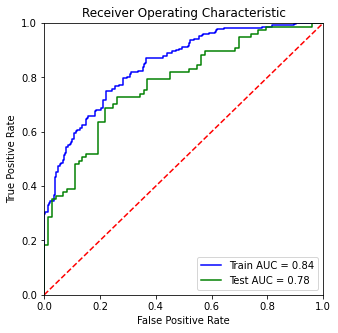

In [15]:
# calculate the false and true positive rates (fpr, tpr)
train_fpr, train_tpr, train_threshold = metrics.roc_curve(y_train, probabilities_train[:,1])
test_fpr, test_tpr, test_threshold = metrics.roc_curve(y_test, probabilities_test[:,1])
#obtain the values for the AUC plot
train_roc_auc = metrics.auc(train_fpr, train_tpr)
test_roc_auc = metrics.auc(test_fpr, test_tpr)
#make the plot
fig, ax = plt.subplots(figsize=[5,5])
plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, 'b', label = 'Train AUC = %0.2f' % train_roc_auc)
plt.plot(test_fpr, test_tpr, 'g', label = 'Test AUC = %0.2f' % test_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Step 5.9: Plot 10 most important features for the model

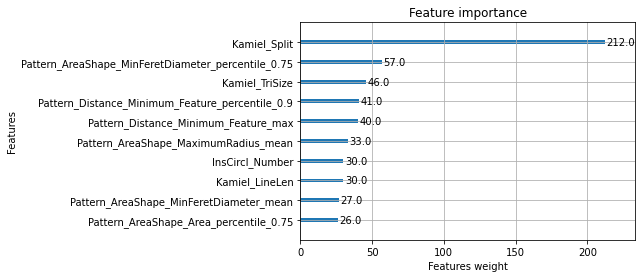

In [16]:
plot_importance(bestClassyficationModel,max_num_features=10,xlabel='Features weight');    
plt.show()

### Step 6: Use SHAP module to explain predicted model

##### Step 6.1: Show which features contribute to prediction of particular surface

In [17]:
explainerDefinition=explainer(dataForModel=X,
          model=bestClassyficationModel,
          hit=1)

Predicted Probability (Bottom, Top): [[0.4878633 0.5121367]]
Predicted Rank (0 = Bottom, 1 = Top): [1] 



##### Step 6.2: Show SHAP values for every important feature and every predicted surface Plot explanation https://shap.readthedocs.io/en/latest/

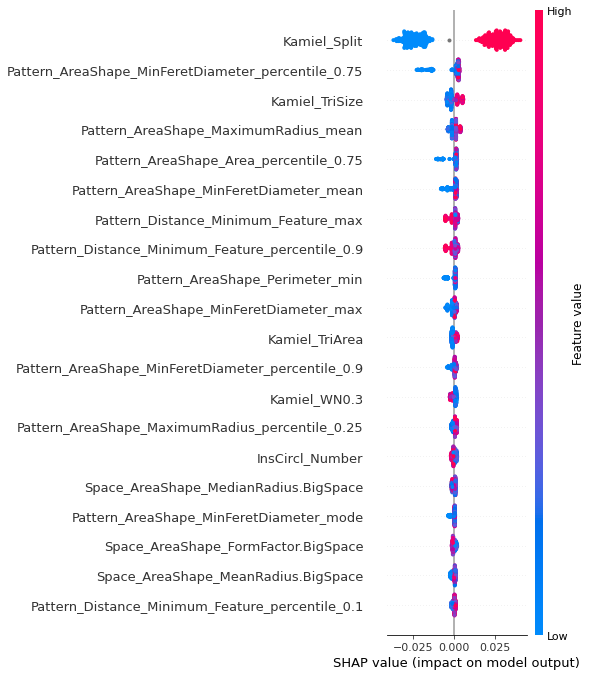

In [18]:
shap_values = explainerDefinition.shap_values(X)
shap.summary_plot(shap_values, X)

##### Step 6.3: Draw a scatter plot with features of interest

Set the feature of interest for the x- and y-axis

In [27]:
xFeature="Kamiel_TriSize"
yFeature="Pattern_AreaShape_MinFeretDiameter_percentile_0.75"

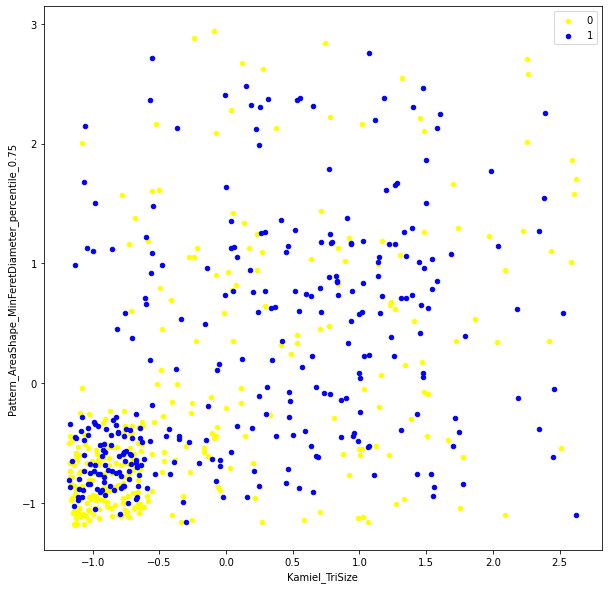

In [28]:
fig, ax = plt.subplots(figsize=[10,10])

colors = {0:'yellow', 1:'blue'}

binned=X
binned["Class"]=Y

grouped = binned.groupby("Class")

for key, group in grouped:
    group.plot(ax=ax, kind='scatter', 
               x=xFeature, 
               y=yFeature, 
               label=key, color=colors[key])

plt.show()